In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn import metrics 

model_dir = '../../models/'

import json
import os
import pandas as pd

from util import gen_model_preds_df, report_metrics

with open('SWDA_dialogue-acts.json') as f:
    swda_tags = json.load(f, strict=False)
swda_tags_list = list(swda_tags)
with open('AMI-DA_dialogue-acts.json') as f:
    ami_tags = json.load(f, strict=False)
ami_tags_list = list(ami_tags)

I0607 21:33:59.290852 140365698176832 file_utils.py:39] PyTorch version 1.2.0 available.
I0607 21:33:59.316937 140365698176832 modeling_xlnet.py:194] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


## In-domain / cross-domain pre-training 
First we want to see how in-domain pre-training compares to cross domain pre-training.

In [2]:
conditions = ['in-domain', 'AMI+SWBD']

pre_corpora = ['SWBD-pre', 'AMI+SWBD-pre']
model_dirs = [f'{model_dir}/SWDA-L_bert_{corpus}_2019-12-03/' for corpus in pre_corpora]
dfs = gen_model_preds_df('SWDA', conditions, model_dirs)

pre_corpora = ['AMI-pre', 'AMI+SWBD-pre']
model_dirs = [f'{model_dir}/AMI-DA-L_bert_{corpus}_2019-12-03/' for corpus in pre_corpora]
dfa = gen_model_preds_df('AMI-DA', conditions, model_dirs)
dfa = dfa[dfa['da_tag'].notnull()]

report_metrics([dfs,dfa], conditions)

3 ../../models//SWDA-L_bert_SWBD-pre_2019-12-03/
4 ../../models//SWDA-L_bert_AMI+SWBD-pre_2019-12-03/
2 ../../models//AMI-DA-L_bert_AMI-pre_2019-12-03/
3 ../../models//AMI-DA-L_bert_AMI+SWBD-pre_2019-12-03/


/nix/store/n1w7861mrhzacybi8vh4xwbxi0q4fgyc-python3-3.7.5-env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/nix/store/n1w7861mrhzacybi8vh4xwbxi0q4fgyc-python3-3.7.5-env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


SWBD       AMI
in-domain macro precision  0.500469  0.524622
          macro recall     0.412848  0.454722
          macro f1         0.436330  0.466406
          micro accuracy   0.770079  0.688198
AMI+SWBD  macro precision  0.589477  0.544517
          macro recall     0.441669  0.469885
          macro f1         0.477812  0.487970
          micro accuracy   0.773529  0.687270

/nix/store/n1w7861mrhzacybi8vh4xwbxi0q4fgyc-python3-3.7.5-env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


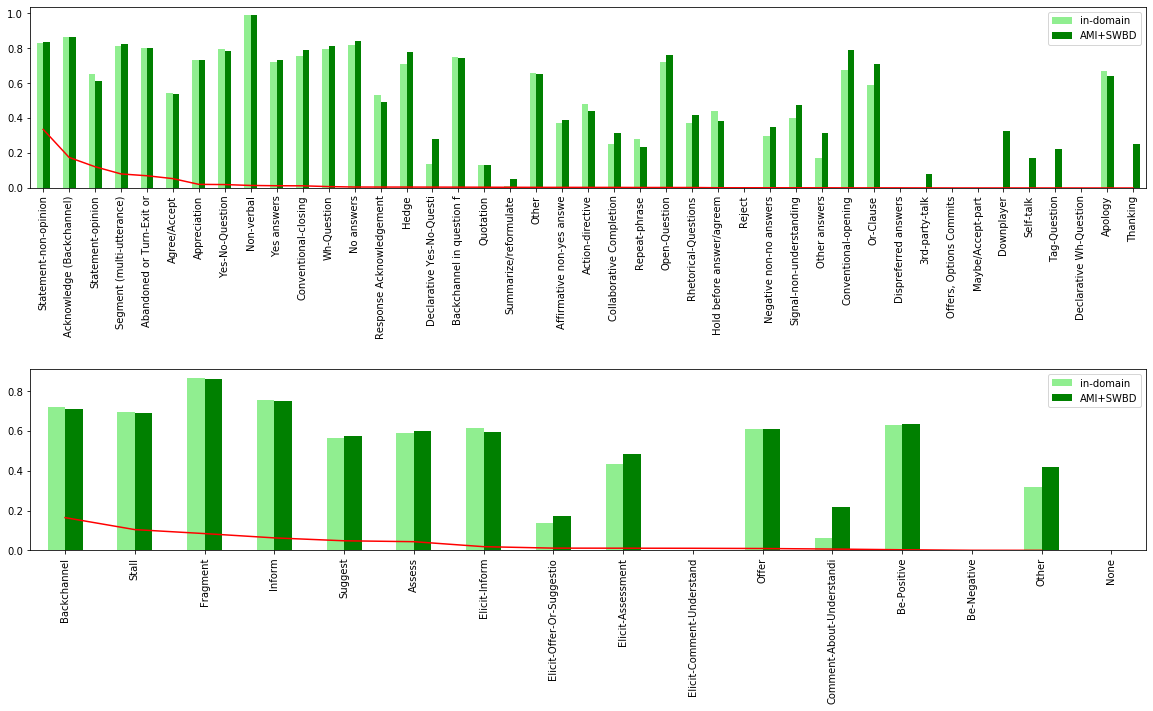

In [3]:
%matplotlib inline

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
plt.subplots_adjust(hspace = 1)
swda_tags_display = {t:swda_tags[t][:25] for t in swda_tags}
ami_tags_display = {t:ami_tags[t][:25] for t in ami_tags}

res = pd.DataFrame([
    metrics.f1_score(dfs['da_tag'], dfs[model], swda_tags_list, average=None)
    for model in conditions],
    index=conditions, columns=swda_tags_list).rename(swda_tags_display, axis=1)
(dfs['da_tag'].value_counts() / len(dfs)).plot(kind='line', color='red', ax=axes[0])
plot = res.T.plot(kind='bar', ax=axes[0], color=['LightGreen', 'Green'])

res = pd.DataFrame([metrics.f1_score(dfa['da_tag'], dfa[model], ami_tags_list, average=None) 
              for model in conditions]
    , index=conditions, columns=ami_tags_list).rename(ami_tags_display, axis=1)
(dfa['da_tag'].value_counts() / len(dfs)).plot(kind='line', color='red', ax=axes[1])
plot = res.T.plot(kind='bar', ax=axes[1], color=['LightGreen', 'Green'])

Pre-training on the combined corpus offers a modest improvement in macro-averaged F1 over simple in-domain pre-training, though there is little effect on micro-averaged performance.
This indicates that pre-training on the lareger, more diverse dataset is helpful for classification of lower-frequency tags. 
A larger pre-training corpus may lead to more significant gains.

In [4]:
conditions = ['BERT-FT', 
              'BERT+ID-FT', 
    'BERT+CD-FT', 'BERT+OS-FT', 'BERT+OS-NL-FT', 'BERT-FZ', 'BERT+ID-FZ', 'BERT+CD-FZ', 'BERT+OS-FZ', 'BERT+OS-NL-FZ']
model_dirs = [
    '{}/{}-L_bert_2019-11-20',
    '{}/{}-L_bert_{}-pre_2019-12-03/',
    '{}/{}-L_bert_AMI+SWBD-pre_2019-12-03/',
    '{}/{}-L_bert_OS-pre_2020-07-14',
    '{}/{}-L_bert_OS-NL-pre_2021-06-04',
    '{}/{}-L_bert_frozen_2019-11-20',
    '{}/{}-L_bert_{}-pre_frozen_2019-12-03',
    '{}/{}-L_bert_AMI+SWBD-pre_frozen_2019-12-03',
    '{}/{}-L_bert_OS-pre_frozen_2020-07-14',
    '{}/{}-L_bert_OS-NL-pre_frozen_2021-06-04',
]

corpus = 'SWDA'
pre_corpus = 'SWBD'
dfs = gen_model_preds_df('SWDA', conditions, [d.format(model_dir, corpus, pre_corpus) for d in model_dirs])
dfs['BASE-MC'] = dfs.da_tag.value_counts().idxmax()

corpus = 'AMI-DA'
pre_corpus = 'AMI'
dfa = gen_model_preds_df('AMI-DA', conditions, [d.format(model_dir, corpus, pre_corpus) for d in model_dirs])
dfa = dfa[dfa['da_tag'].notnull()]
dfa['BASE-MC'] = dfa.da_tag.value_counts().idxmax()


pd.options.display.float_format = '{:,.2f}'.format
a=report_metrics([dfs,dfa], conditions + ['BASE-MC']).swaplevel(0,1).sort_index(0) * 100
a

2 ../../models//SWDA-L_bert_2019-11-20
3 ../../models//SWDA-L_bert_SWBD-pre_2019-12-03/
4 ../../models//SWDA-L_bert_AMI+SWBD-pre_2019-12-03/
3 ../../models//SWDA-L_bert_OS-pre_2020-07-14
3 ../../models//SWDA-L_bert_OS-NL-pre_2021-06-04
8 ../../models//SWDA-L_bert_frozen_2019-11-20
9 ../../models//SWDA-L_bert_SWBD-pre_frozen_2019-12-03
9 ../../models//SWDA-L_bert_AMI+SWBD-pre_frozen_2019-12-03
9 ../../models//SWDA-L_bert_OS-pre_frozen_2020-07-14
9 ../../models//SWDA-L_bert_OS-NL-pre_frozen_2021-06-04
2 ../../models//AMI-DA-L_bert_2019-11-20
2 ../../models//AMI-DA-L_bert_AMI-pre_2019-12-03/
3 ../../models//AMI-DA-L_bert_AMI+SWBD-pre_2019-12-03/
3 ../../models//AMI-DA-L_bert_OS-pre_2020-07-14
2 ../../models//AMI-DA-L_bert_OS-NL-pre_2021-06-04
9 ../../models//AMI-DA-L_bert_frozen_2019-11-20
9 ../../models//AMI-DA-L_bert_AMI-pre_frozen_2019-12-03
9 ../../models//AMI-DA-L_bert_AMI+SWBD-pre_frozen_2019-12-03
9 ../../models//AMI-DA-L_bert_OS-pre_frozen_2020-07-14
9 ../../models//AMI-DA-L_bert_

SWBD   AMI
macro f1        BASE-MC        1.17  2.94
                BERT+CD-FT    47.78 48.80
                BERT+CD-FZ     5.76 11.33
                BERT+ID-FT    43.63 46.64
                BERT+ID-FZ     6.46 14.47
                BERT+OS-FT    41.62 48.59
                BERT+OS-FZ     9.60 17.02
                BERT+OS-NL-FT 43.71 43.68
                BERT+OS-NL-FZ  7.69 16.99
                BERT-FT       36.75 43.37
                BERT-FZ        7.75 14.85
macro precision BASE-MC        0.78  1.88
                BERT+CD-FT    58.95 54.45
                BERT+CD-FZ     8.69 12.30
                BERT+ID-FT    50.05 52.46
                BERT+ID-FZ     7.74 27.11
                BERT+OS-FT    49.87 54.52
                BERT+OS-FZ    10.55 16.55
                BERT+OS-NL-FT 54.42 49.38
                BERT+OS-NL-FZ 10.41 16.38
                BERT-FT       43.47 48.97
                BERT-FZ       12.05 14.60
macro recall    BASE-MC        2.33  6.67
                BERT+CD-FT    44.17 46.99
                BERT+CD-FZ     6.91 12.97
                BERT+ID-FT    41.28 45.47
                BERT+ID-FZ     7.73 17.51
                BERT+OS-FT    40.01 47.27
                BERT+OS-FZ    10.77 20.22
                BERT+OS-NL-FT 40.98 43.02
                BERT+OS-NL-FZ  8.34 20.10
                BERT-FT       35.15 43.08
                BERT-FZ        8.32 18.18
micro accuracy  BASE-MC       33.56 28.27
                BERT+CD-FT    77.35 68.73
                BERT+CD-FZ    51.14 40.46
                BERT+ID-FT    77.01 68.82
                BERT+ID-FZ    52.30 48.15
                BERT+OS-FT    76.95 68.02
                BERT+OS-FZ    57.67 51.01
                BERT+OS-NL-FT 77.09 64.80
                BERT+OS-NL-FZ 55.29 51.46
                BERT-FT       76.60 64.87
                BERT-FZ       55.61 48.30

In [5]:
print(a.to_latex(multirow=True))

\begin{tabular}{llrr}
\toprule
               &         &  SWBD &   AMI \\
\midrule
\multirow{11}{*}{macro f1} & BASE-MC &  1.17 &  2.94 \\
               & BERT+CD-FT & 47.78 & 48.80 \\
               & BERT+CD-FZ &  5.76 & 11.33 \\
               & BERT+ID-FT & 43.63 & 46.64 \\
               & BERT+ID-FZ &  6.46 & 14.47 \\
               & BERT+OS-FT & 41.62 & 48.59 \\
               & BERT+OS-FZ &  9.60 & 17.02 \\
               & BERT+OS-NL-FT & 43.71 & 43.68 \\
               & BERT+OS-NL-FZ &  7.69 & 16.99 \\
               & BERT-FT & 36.75 & 43.37 \\
               & BERT-FZ &  7.75 & 14.85 \\
\cline{1-4}
\multirow{11}{*}{macro precision} & BASE-MC &  0.78 &  1.88 \\
               & BERT+CD-FT & 58.95 & 54.45 \\
               & BERT+CD-FZ &  8.69 & 12.30 \\
               & BERT+ID-FT & 50.05 & 52.46 \\
               & BERT+ID-FZ &  7.74 & 27.11 \\
               & BERT+OS-FT & 49.87 & 54.52 \\
               & BERT+OS-FZ & 10.55 & 16.55 \\
               & BERT+OS-NL-FT & 

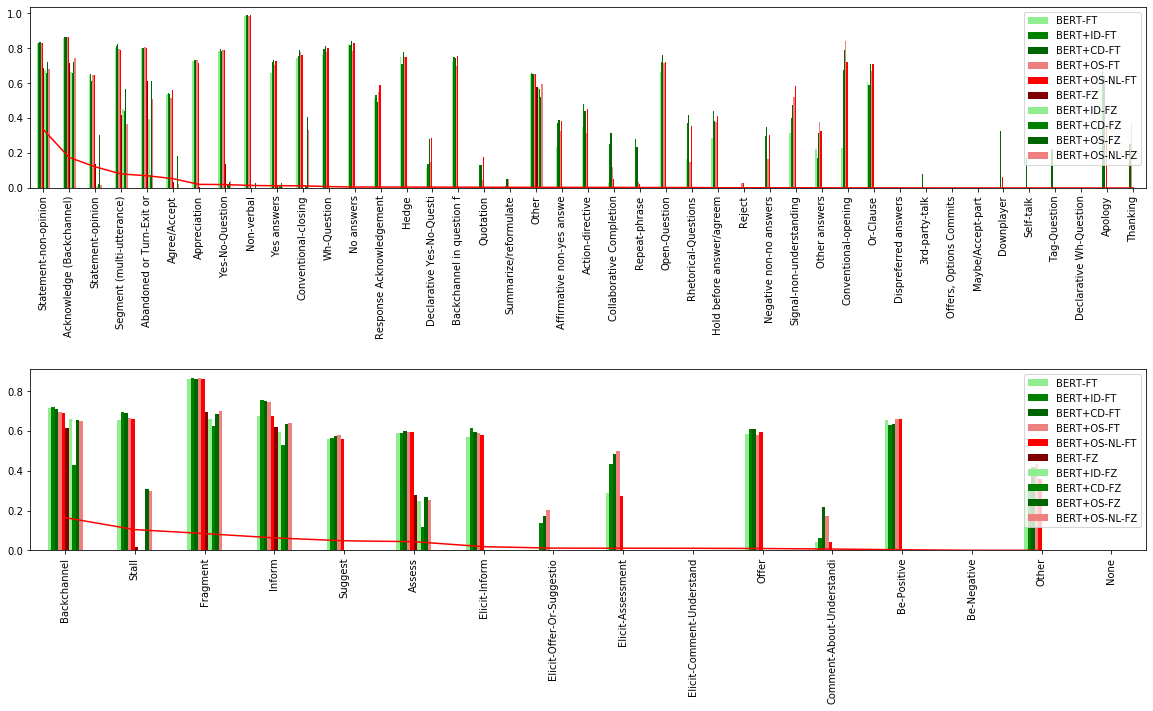

In [6]:
%matplotlib inline

colors = ['LightGreen', 'Green', 'DarkGreen', 'LightCoral', 'Red', 'Maroon']
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
plt.subplots_adjust(hspace = 1)
swda_tags_display = {t:swda_tags[t][:25] for t in swda_tags}
ami_tags_display = {t:ami_tags[t][:25] for t in ami_tags}

res = pd.DataFrame([
    metrics.f1_score(dfs['da_tag'], dfs[model], swda_tags_list, average=None)
    for model in conditions],
    index=conditions, columns=swda_tags_list).rename(swda_tags_display, axis=1)
(dfs['da_tag'].value_counts() / len(dfs)).plot(kind='line', color='red', ax=axes[0])
plot = res.T.plot(kind='bar', ax=axes[0], color=colors)

res = pd.DataFrame([metrics.f1_score(dfa['da_tag'], dfa[model], ami_tags_list, average=None) 
              for model in conditions]
    , index=conditions, columns=ami_tags_list).rename(ami_tags_display, axis=1)
(dfa['da_tag'].value_counts() / len(dfs)).plot(kind='line', color='red', ax=axes[1])
plot = res.T.plot(kind='bar', ax=axes[1], color=colors)

The effect of additional pre-training is mixed. For AMI it appears that in-domain pre-training offers a modest performance boost, but there is no discernable effect in the case of Switchboard. Indeed, when BERT is frozen during fine-tuning, the model that received no additional pre-traininig performs better by more than 3 percentage points. 

In [7]:
conditions = ['addl-pre', 'standard', 'addl-pre-NL', 'standard-NL']

model_dirs = [
    '../../models/SWDA-L_bert_SWBD-pre_2019-12-03/',
    '../../models/SWDA-L_bert_2019-11-20',
    '../../models/SWDA-NL_bert_SWBD-pre_2019-12-03/',
    '../../models/SWDA-NL_bert_2019-11-20']
dfs = gen_model_preds_df('SWDA', conditions, model_dirs)

model_dirs = [
    '../../models/AMI-DA-L_bert_AMI-pre_2019-12-03/',
    '../../models/AMI-DA-L_bert_2019-11-20',
    '../../models/AMI-DA-NL_bert_AMI-pre_2019-12-03/',
    '../../models/AMI-DA-NL_bert_2019-11-20']
dfa = gen_model_preds_df('AMI-DA', conditions, model_dirs)
dfa = dfa[dfa['da_tag'].notnull()]


report_metrics([dfs,dfa], conditions)

3 ../../models/SWDA-L_bert_SWBD-pre_2019-12-03/
2 ../../models/SWDA-L_bert_2019-11-20
3 ../../models/SWDA-NL_bert_SWBD-pre_2019-12-03/
../../models/SWDA-NL_bert_SWBD-pre_2019-12-03/preds.E3.json
2 ../../models/SWDA-NL_bert_2019-11-20
2 ../../models/AMI-DA-L_bert_AMI-pre_2019-12-03/
2 ../../models/AMI-DA-L_bert_2019-11-20
3 ../../models/AMI-DA-NL_bert_AMI-pre_2019-12-03/
../../models/AMI-DA-NL_bert_AMI-pre_2019-12-03/preds.E3.json
2 ../../models/AMI-DA-NL_bert_2019-11-20


KeyError: 'addl-pre-NL'

## Mutual information of BERT layers

We want to compare standard pre-trained BERT to:

- BERT-FT
- BERT+ID

for SWDA and AMI-DA

In [3]:
import torch
import transformers
from EDGE.EDGE_4_3_1 import EDGE

In [17]:
# X = transformers.BertModel.from_pretrained('bert-base-uncased')
# X.save_pretrained('../../models/bert-official')
X = torch.load('../../models/bert-official/pytorch_model.bin')

In [38]:
model_dirs = {
    'BERT-FT (AMI)': "AMI-DA-L_bert_2019-11-20/encoder_model.E6.bin",
    'BERT-FT (SWDA)': "SWDA-L_bert_2019-11-20/encoder_model.E4.bin",
    'BERT+ID (AMI)': "pretrained_AMI/pytorch_model.bin",
    'BERT+ID (SWDA)': "pretrained_SWBD/pytorch_model.bin" 
}
layer_X = 'encoder.layer.{}.output.dense.weight'
layer_Y = 'bert.encoder.layer.{}.output.dense.weight'

from collections import defaultdict
I = defaultdict(dict)
for model in model_dirs:
    Y = torch.load(f"../../models/{model_dirs[model]}")
    for layer in range(12):
        I[model][layer] = EDGE(X[layer_X.format(layer)].cpu().numpy(),Y[layer_Y.format(layer)].cpu().numpy(), ensemble_estimation='mean')

UnboundLocalError: local variable 'I' referenced before assignment

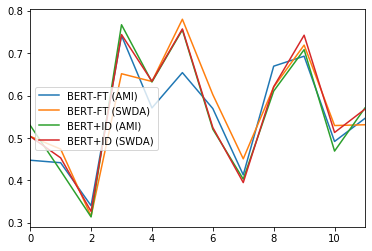

In [35]:
%matplotlib inline

import pandas as pd
pd.DataFrame(I).plot(kind='line')

In [36]:
pd.DataFrame(I)

,BERT-FT (AMI),BERT-FT (SWDA),BERT+ID (AMI),BERT+ID (SWDA)
0,0.447520,0.503748,0.529704,0.503735
1,0.441681,0.473828,0.422673,0.453165
2,0.340456,0.315657,0.314014,0.327089
3,0.741119,0.651278,0.766692,0.743574
4,0.570732,0.633044,0.631847,0.633496
5,0.653884,0.779627,0.754642,0.756779
6,0.569248,0.602020,0.520604,0.524598
7,0.413061,0.450852,0.403005,0.394916
8,0.669093,0.619938,0.610492,0.620731
9,0.692616,0.718790,0.707966,0.742006


In [5]:
a['bert.encoder.layer.0.output.dense.weight']

tensor([[-0.0407, -0.0168,  0.0290,  ..., -0.0067,  0.0114,  0.0125],
        [ 0.0633, -0.0123,  0.0473,  ..., -0.0026, -0.0202, -0.0029],
        [ 0.0059, -0.0687,  0.0397,  ..., -0.0037,  0.0331,  0.0035],
        ...,
        [-0.0407, -0.0230,  0.0118,  ...,  0.0098,  0.0127,  0.0201],
        [-0.0680,  0.0285,  0.0281,  ..., -0.0119, -0.0535,  0.0518],
        [-0.0532,  0.0052,  0.0020,  ...,  0.0307,  0.0060,  0.0297]],
       device='cuda:0')

In [28]:
import os
os.listdir(f"../../data")

['SWBD_pretraining.txt',
 'AMI-DA_val.json',
 'swda_vocab.json',
 'glove.6B.zip',
 'AMI-DA_tags.txt',
 'SWDA_train.json',
 'bert-base-uncased-vocab.SWDA.txt',
 'AMI-DA_train.json',
 'AMI',
 'SWDA_tags.txt',
 'SWDA_test.json',
 'AMI-DA_test.json',
 'SWDA_val.json',
 '__MACOSX',
 'bert-base-uncased_vocab.txt',
 'SWBD_pretraining',
 'bert-base-uncased_config.json',
 'AMI_pretraining',
 'swda',
 'glove.6B',
 'AMI+SWBD_pretraining',
 'SWDA',
 'swda_tag_vocab.json',
 'AMI_pretraining.txt',
 'SWDA_splits.json',
 'AMI+SWBD_pretraining.txt',
 'ami_public_manual_1.6.2.zip',
 'AMI-noDA.json',
 'AMI-DA_splits.json']

In [27]:
transformers.__version__

'2.1.1'